# Neural network in numpy


In this notebook, we construct, initialize and train a simple neural network (multilayer perceptron) from scratch, using only `numpy`.

We define a **classifier network** consisting of:
- 2 input units
- `n` hidden units with **ReLU** activation
- 2 outputs using **softmax** activation

We use **categorical crossentropy** as our loss function

## Things to try

- change data set (e.g. `make_circle`)
- change noise in data
- try to overfit
- change `relu` for `sigmoid`

- import `numpy` and `matplotlib` for plotting

In [1]:
import numpy as np 
import matplotlib.pylab as plt

%matplotlib inline

- define a few utility functions for plotting history, data and predictions  (Not to important for you)

In [2]:
def plot_history(history):
    '''plot loss over time'''
    lists = sorted(history.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists)
    labels=['train', 'test']
    for y_arr, label in zip(np.array(y).T, labels):
        plt.plot(x, y_arr, '-o', label=label)
    #plt.plot(x, y, '-o', label=labels)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_data(x, t_classes):
    '''scatter plot of 2D data points, colored according to ground truth classes'''
    plt.scatter(*x.T, c=t_classes, s=200, alpha=0.4, label='ground truth')
    plt.legend()

def plot_prediction(model, x, t_classes):
    '''scatter plot of 2D data points, with predictions (small) and ground truth labels (large)'''
    y = predict(model, x)
    plt.scatter(*x.T, c=y, s=50, alpha=1.0, label='prediction')
    plot_data(x, t_classes)
    #plt.scatter(*x.T, c=t_classes, s=200, alpha=0.4, label='ground truth')
    plt.legend()

def plot_prediction_with_decision_boundary(model, x, t_classes, resolution=200):
    '''scatter plot of 2D data points, with predictions (small) and ground truth labels (large), 
    also including the decision boundary as background.'''

    # create lattice of points
    fig = plt.gcf()
    margin = 1.1
    xregion=[x[:,0].min()*margin, x[:,0].max()*margin]
    yregion=[x[:,1].min()*margin, x[:,1].max()*margin]
    xticks = np.linspace(*xregion, resolution)
    yticks = np.linspace(*yregion, resolution)
    p1,p2 = np.meshgrid(xticks, yticks)
    p = np.array([p1.flatten(), p2.flatten()]).T
    # predict class on all points of the lattice
    output = feed_forward(model, p)
    preds_bg = np.argmax(output[-1], axis=1)
    # plot prediction are colored surface
    _ = plt.contourf(p1, p2, preds_bg.reshape(len(xticks),len(yticks)), alpha=0.4, cmap='jet')
    plot_prediction(model, x, t_classes)

def to_onehot_encoding(y):
    '''Convert from class values to one-hot notation'''
    assert y.ndim == 1
    num_samples = len(y)
    num_classes = np.max(y)+1
    onehot = np.zeros((num_samples, num_classes), np.uint8)
    onehot[np.arange(num_samples), y] = 1
    return onehot

### Functions (relu, softmax, crossentropy)

- define ReLU and its derivative
- ReLU is used as activation function of the hidden layer

In [3]:
def relu(x):
    return np.maximum(x, 0)

def relu_derivative(x):
    return (x > 0)

- define softmax function 
- used in output layer of our classifier

In [4]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

- define crossentropy loss function

In [5]:
def cross_entropy(t, y_pred):
    return - np.sum( t * np.log(y_pred) )

### Neural network

- construct model, using He weights initialization

In [6]:
def build_model(n_inputs, n_hidden_units, n_outputs):
    model = {}
    model['W1'] = np.random.rand(n_inputs, n_hidden_units) * np.sqrt(2.0/n_inputs)
    model['b1'] = np.zeros(n_hidden_units)
    model['W2'] = np.random.rand(n_hidden_units, n_outputs) * np.sqrt(2.0/n_hidden_units)
    model['b2'] = np.zeros(n_outputs)
    return model

- forward propagation 

In [7]:
def feed_forward(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    # Activations hidden layer
    z1 = np.dot(x, W1) + b1
    a1 = relu( z1 )

    # Activations of output layer
    z2 = np.dot(a1, W2) + b2

    output = softmax( z2 )
    
    return a1, output

def predict(model, x):
    '''prediction is one forward pass through the model, returns class predictions (max probable classes)'''
    _, output = feed_forward(model, x)
    return np.argmax(output, axis=1)

- loss and metric functions

In [8]:
def calculate_loss(y_true, y_pred):
    num_samples = y_true.shape[0]
    return cross_entropy(y_true, y_pred) / num_samples

def accuracy(y_true, y_pred):
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    return (np.abs(y_true - y_pred) < 0.5 ).all(axis=1).mean()

- back propagation algorithm

In [9]:
def backprop(model, y_true, x, a1, output):

    # error for each output units. shape = (n_samples, n_outputs)
    # dL/dz = dL/dy . dy/dz = derivative_xe . derivative_softmax
    delta3 = (output - y_true)
    
    # error for hidden units. shape = (n_samples, n_hidden_units)
    # dL/dz = dL/do . dy/dz
    delta2 = np.dot( delta3, model['W2'].T) * relu_derivative(a1) 
    
    # dL / dW2
    dW2 = np.dot( a1.T, delta3) 
    # dL / db2
    db2 = np.sum( delta3, axis=0, keepdims=0) 
    
    # dL / dW1
    dW1 = np.dot( x.T, delta2) 
    # dL / db1
    db1 = np.sum( delta2, axis=0, keepdims=0) 

    return dW1, db1, dW2, db2

- optimization algorithm (gradient descent)

In [10]:
def update_params(model, learning_rate, deltas):
    # update weights and biases according to gradient descent
    
    dW1, db1, dW2, db2 = deltas
    
    model['W1'] -= learning_rate * dW1
    model['b1'] -= learning_rate * db1
    model['W2'] -= learning_rate * dW2
    model['b2'] -= learning_rate * db2
    
    return model

- putting everything together in a `fit` function:
  - for `n_epochs`, do:
    - forward propagation of all data through the model
    - calculate deltas for all parameters using backpropagation
    - update model parameters
    - once every 1000 epochs: 
      - calculate and output progress
      - terminate is `loss < threshold`
    

In [11]:
def fit(model, x, t, n_epochs, learning_rate, x_test=None, t_test=None, threshold=0.01):
    
    history = {}
    for i in range(n_epochs):
        
        # feed forward: predict output
        a1, output = feed_forward(model, x)
        
        # backpropagation: calculate gradients
        deltas = backprop(model, t, x, a1, output)
        
        # optimization: update weights and biases
        model = update_params(model, learning_rate, deltas)
        
        
        if i % 1000 == 0:
            # calculate loss
            loss = calculate_loss(t, output)

            # accuracy
            acc = accuracy(t, output)
            
            loss_test = None
            if x_test is not None and t_test is not None:
                a1, output = feed_forward(model, x_test)
                loss_test = calculate_loss(t_test, output)
                val_acc = accuracy(t_test, output)
                print("epochs {: >5d} : loss = {:.2f}, val_loss = {:.2f}, acc = {:.2f}, val_acc = {:.2f}, ".format(i, loss, loss_test, acc, val_acc))
            else:
                print("epochs {: >5d} : loss = {:.2f}, acc = {:.2f}".format(i, loss, acc))
            history[i] = (loss, loss_test)
            
            if loss < 0.01:
                break

    return history

### Generate data set

- we generate data points using `sklearn.datasets`
- you can choose the data set by uncommenting the relevant lines: 
  - `make_moons` 
  - `make_circles` 
  - `make_blobs` 
- you can change the difficulty of classification by changing the following parameters:
  - `make_moons`: `noise` amplitude
  - `make_circles`: `noise` amplitude
  - `make_blobs`: `cluster_std`



array([1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1])

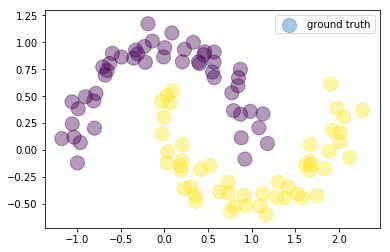

In [12]:
from sklearn import datasets
x, t_classes = datasets.make_moons(n_samples=100, noise=0.1, random_state=42)
#x, t_classes = datasets.make_circles(n_samples=100, factor=0.7, noise=0.1, random_state=42) 
#x, t_classes = datasets.make_blobs(n_samples=100, centers=2, cluster_std=1.0 center_box=[-2, 2], random_state=42)

plot_data(x, t_classes)
t = to_onehot_encoding(t_classes)
t_classes

- split data into train and test set using `train_test_split`

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.33, random_state=42)

num_features = x_train.shape[-1]
num_samples  = x_train.shape[0]
num_classes  = t_train.shape[-1]
print("Shape of inputs  = ", x.shape)
print("Shape of targets = ", t_train.shape)

n_inputs       = num_features
n_hidden_units = 128
n_outputs      = num_classes
model = build_model(n_inputs, n_hidden_units, n_outputs)

Shape of inputs  =  (100, 2)
Shape of targets =  (67, 2)


### Construct and train neural net

- construct NN model

In [14]:
n_inputs       = num_features
n_hidden_units = 128
n_outputs      = num_classes
model = build_model(n_inputs, n_hidden_units, n_outputs)

- fit NN model to training data 

In [15]:
%%time
history = fit(model, x_train, t_train, 
                n_epochs=10000, learning_rate=0.001, 
                x_test=x_test, t_test=t_test)

epochs     0 : loss = 0.68, val_loss = 0.72, acc = 0.85, val_acc = 0.45, 
epochs  1000 : loss = 0.26, val_loss = 0.23, acc = 0.85, val_acc = 0.91, 
epochs  2000 : loss = 0.25, val_loss = 0.22, acc = 0.85, val_acc = 0.91, 
epochs  3000 : loss = 0.25, val_loss = 0.21, acc = 0.85, val_acc = 0.91, 
epochs  4000 : loss = 0.25, val_loss = 0.21, acc = 0.85, val_acc = 0.91, 
epochs  5000 : loss = 0.13, val_loss = 0.12, acc = 0.94, val_acc = 0.97, 
epochs  6000 : loss = 0.05, val_loss = 0.07, acc = 1.00, val_acc = 0.97, 
epochs  7000 : loss = 0.03, val_loss = 0.05, acc = 1.00, val_acc = 0.97, 
epochs  8000 : loss = 0.02, val_loss = 0.04, acc = 1.00, val_acc = 1.00, 
epochs  9000 : loss = 0.01, val_loss = 0.03, acc = 1.00, val_acc = 1.00, 
CPU times: user 2.39 s, sys: 0 ns, total: 2.39 s
Wall time: 2.39 s


- plot the history
  - blue: train data
  - orange: test data 
  

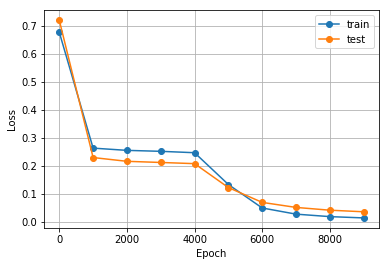

In [16]:
_ = plot_history(history)

### Predict output

- plot predictions
  - small solid points are predictions
  - large transparent points represent ground truth

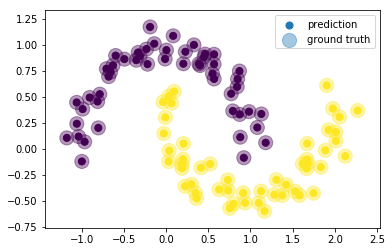

In [17]:
plot_prediction(model, x, t_classes)
plt.show()

- plot prediction with decision boundary

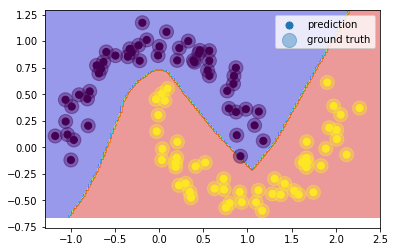

In [18]:
plot_prediction_with_decision_boundary(model, x, t_classes)
plt.show()

## Equivalent network in `keras`

In [20]:
import tensorflow as tf
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Dense(n_hidden_units, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(n_outputs, activation='softmax')
])

model.compile(optimizer='sgd', loss='categorical_crossentropy')

_ = model.fit(x_train, t_train, 
          batch_size = len(x_train),
          epochs=1000,
          validation_data=(x_test, t_test),
          verbose=0)

### PLEASE RUN THIS COMMAND IF YOU FINISHED THE NOTEBOOK

In [ ]:
import os
temp=os.getpid()
!kill -9 $temp